In [476]:
%config Completer.use_jedi = True

# AC FEUP 21/22

## Main dependencies

In [477]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import numpy as np
import sklearn

# use to not cut columns
pd.set_option('max_columns', None)

# njobs to use in sklearn models
configNJobs = -1

## Import data

### Training data

In [478]:
# import data
def read_csv(file, dtype={}, na_values=None):
    return pd.read_csv("data/" + file, sep=";", dtype=dtype, na_values=na_values)

account_df = read_csv("account.csv")
card_df = read_csv("card_train.csv")
client_df = read_csv("client.csv")
disp_df = read_csv("disp.csv")
district_df = read_csv("district.csv", na_values="?")
loan_df = read_csv("loan_train.csv")
trans_df = read_csv("trans_train.csv", dtype={'bank': 'str'})

trans_df.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1548749,5270,930113,credit,credit in cash,800.0,800.0,NaN,NaN,NaN
1,1548750,5270,930114,credit,collection from another bank,44749.0,45549.0,NaN,IJ,80269753.0
2,3393738,11265,930114,credit,credit in cash,1000.0,1000.0,NaN,NaN,NaN
3,3122924,10364,930117,credit,credit in cash,1100.0,1100.0,NaN,NaN,NaN
4,1121963,3834,930119,credit,credit in cash,700.0,700.0,NaN,NaN,NaN


In [479]:
# clean column names (some columns come with an extra whitespace)
district_df.rename(columns=lambda x: x.strip(), inplace=True)

# rename some columns for easier interaction
district_df.rename(columns={"no. of inhabitants": "people_count",
                            "no. of municipalities with inhabitants < 499": "muni_499_count",
                            "no. of municipalities with inhabitants 500-1999": "muni_500-1999_count",
                            "no. of municipalities with inhabitants 2000-9999": "muni_2000-9999_count",
                            "no. of municipalities with inhabitants >10000": "muni_10000_count",
                            "no. of cities": "cities_count",
                            "ratio of urban inhabitants": "ratio_urban_people",
                            "average salary": "avg_salary",
                            "unemploymant rate '95": "unemp_rate_95",
                            "unemploymant rate '96": "unemp_rate_96",
                            "no. of enterpreneurs per 1000 inhabitants": "enterp_per1000",
                            "no. of commited crimes '95": "crime_count_95",
                            "no. of commited crimes '96": "crime_count_96"},
                   inplace=True)
district_df.head()

,code,name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,unemp_rate_95,unemp_rate_96,enterp_per1000,crime_count_95,crime_count_96
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677.0,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159.0,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824.0,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244.0,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616.0,3040


### Test data

In [480]:
card_test_df = read_csv("card_test.csv")
loan_test_df = read_csv("loan_test.csv")
trans_test_df = read_csv("trans_test.csv", dtype={'bank': 'str'})

## Dealing with missing values

### Account data

In [481]:
account_df.isnull().sum()

account_id     0
district_id    0
frequency      0
date           0
dtype: int64

No NULL data to deal with on this dataframe.

### Card data

In [482]:
card_df.isnull().sum()

card_id    0
disp_id    0
type       0
issued     0
dtype: int64

No NULL data to deal with on this dataframe.

In [483]:
card_test_df.isnull().sum()

card_id    0
disp_id    0
type       0
issued     0
dtype: int64

### Client data

In [484]:
client_df.isnull().sum()

client_id       0
birth_number    0
district_id     0
dtype: int64

There are no NULL values on this dataset to deal with.

### Disposition data

In [485]:
disp_df.isnull().sum()

disp_id       0
client_id     0
account_id    0
type          0
dtype: int64

No NULL data to deal with on this dataframe.

### District data

In [486]:
district_df.isnull().sum()

code                    0
name                    0
region                  0
people_count            0
muni_499_count          0
muni_500-1999_count     0
muni_2000-9999_count    0
muni_10000_count        0
cities_count            0
ratio_urban_people      0
avg_salary              0
unemp_rate_95           1
unemp_rate_96           0
enterp_per1000          0
crime_count_95          1
crime_count_96          0
dtype: int64

There is 1 NULL value in _unemploymant rate '95_ and _no. of commited crimes '95_.

In [487]:
district_df[district_df["unemp_rate_95"].isnull()]

,code,name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,unemp_rate_95,unemp_rate_96,enterp_per1000,crime_count_95,crime_count_96
68,69,Jesenik,north Moravia,42821,4,13,5,1,3,48.4,8173,NaN,7.01,124,NaN,1358


Both of these missing value are for the district of _Jesenik_. We can find the mean growth/shrinkage of the unemploymant and number of crimes commit from 1995 to 1996, and use that to fill the missing values of 1995 for this district.

In [488]:
unem_rate_95 = district_df[district_df["unemp_rate_95"].notnull()]["unemp_rate_95"]
unem_rate_96 = district_df[district_df["unemp_rate_96"].notnull()]["unemp_rate_96"]

unem_growth_series = unem_rate_95 / unem_rate_96
unem_growth = unem_growth_series.sum() / unem_growth_series.count()

district_df["unemp_rate_95"] = district_df.apply(lambda x: x["unemp_rate_96"] * unem_growth if np.isnan(x["unemp_rate_95"]) else x["unemp_rate_95"], axis=1)

In [489]:
no_crime_95 = district_df[district_df["crime_count_95"].notnull()]["crime_count_95"]
no_crime_96 = district_df[district_df["crime_count_96"].notnull()]["crime_count_96"]

crime_growth_series = no_crime_95 / no_crime_96
crime_growth = crime_growth_series.sum() / crime_growth_series.count()

district_df["crime_count_95"] = district_df.apply(lambda x: x["crime_count_96"] * crime_growth if np.isnan(x["crime_count_95"]) else x["crime_count_95"], axis=1)

In [490]:
district_df[district_df["code"] == 69]

,code,name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,unemp_rate_95,unemp_rate_96,enterp_per1000,crime_count_95,crime_count_96
68,69,Jesenik,north Moravia,42821,4,13,5,1,3,48.4,8173,5.759683,7.01,124,1321.520511,1358


The missing values have been taken care of.

### Loan data

In [491]:
loan_df.isnull().sum()

loan_id       0
account_id    0
date          0
amount        0
duration      0
payments      0
status        0
dtype: int64

There are no NULL values to fill on this dataframe.

In [492]:
loan_test_df.isnull().sum()

loan_id         0
account_id      0
date            0
amount          0
duration        0
payments        0
status        354
dtype: int64

These missing values (_status_) don't matter as they are the targets of our prediction model.

### Transaction data

In [493]:
trans_df.isnull().sum()

trans_id           0
account_id         0
date               0
type               0
operation      70761
amount             0
balance            0
k_symbol      185244
bank          299443
account       294456
dtype: int64

In [494]:
trans_test_df.isnull().sum()

trans_id          0
account_id        0
date              0
type              0
operation      5130
amount            0
balance           0
k_symbol      17419
bank          24377
account       21061
dtype: int64

There are 4 attributes with a large quantity of null values on this dataframe that have to dealt with: _operation_, _k\_symbol_, _bank_, and _account_.

In [495]:
trans_df['operation'].value_counts()

withdrawal in cash              165270
remittance to another bank       70737
credit in cash                   62202
collection from another bank     26505
credit card withdrawal            1210
Name: operation, dtype: int64

In [496]:
len(trans_df[trans_df['operation'].isnull()]) / len(trans_df['operation']) * 100.0

17.838083113805663

The _operation_ attribute is categorical and doesn't reveal an inherited order. It can be enconded with 3 attributes using binary encoding.

This attribute is problematic because it contains a significant number of NULL values ($17.8\%$).

It was decided that these rows will be filled with _unkown_.

In [497]:
trans_df['operation'].fillna('unknown', inplace=True)

trans_test_df['operation'].fillna('unknown', inplace=True)

In [498]:
trans_df['k_symbol'].value_counts()

interest credited                        70761
payment for statement                    58377
household                                42839
                                         19065
old-age pension                          13502
insurrance payment                        6592
sanction interest if negative balance      305
Name: k_symbol, dtype: int64

There is a category that is an empty string. It is likelly that the missing values were intended to be part of this category aswell. It is assumed that these rows with the _empty_ category refer to common transactions that aren't related to pensions, insurrance, etc... The missing values and the empty rows of this attribute will be renamed to _no_symbol_.

In [499]:
def treat_null_k_symbol(row):
    k_symb = row['k_symbol']
    if isinstance(k_symb, float):
        return 'no_symbol'
    elif k_symb == " ":
        return 'no_symbol'
    else:
        return k_symb
    

trans_df['k_symbol'] = trans_df.apply(treat_null_k_symbol, axis=1)
trans_test_df['k_symbol'] = trans_test_df.apply(treat_null_k_symbol, axis=1)

trans_df['k_symbol'].value_counts()

no_symbol                                204309
interest credited                         70761
payment for statement                     58377
household                                 42839
old-age pension                           13502
insurrance payment                         6592
sanction interest if negative balance       305
Name: k_symbol, dtype: int64

There many rows where we don't know which is the bank of the partner.

In [500]:
trans_df['bank'].value_counts()

ST    8114
GH    7886
EF    7878
AB    7666
UV    7618
OP    7595
IJ    7536
YZ    7471
QR    7413
KL    7397
WX    7033
CD    7009
MN    6626
Name: bank, dtype: int64

In [501]:
trans_df['account'].value_counts()

0.0           4987
15916598.0      48
62457513.0      48
6149286.0       48
42988401.0      48
              ... 
99218499.0       1
54261672.0       1
28306174.0       1
91523855.0       1
53761804.0       1
Name: account, Length: 4536, dtype: int64

The unknown information about the partner's bank tranlates to unkown information about the partner. This is sometimes represented by a **0** on the _account_ attribute.

In [502]:
print("Number of unknown banks:", len(trans_df[trans_df['bank'].isnull()]))
print("Number of unknown partners:", len(trans_df[trans_df['account'].isnull()]) + len(trans_df[trans_df['account'] == 0]))

Number of unknown banks: 299443
Number of unknown partners: 299443


The number of unknown banks is the same as the number of unkown partners => these 2 features are highly correlated. Even though these 2 attributes aren't likelly to contribute anything to our dataset, we can create an **'unknown' bank** and set all unkown _account_ attributes to 0.

In [503]:
trans_df['account'].fillna(0, inplace=True)
trans_df['bank'].fillna("unknown", inplace=True)

trans_test_df['account'].fillna(0, inplace=True)
trans_test_df['bank'].fillna("unknown", inplace=True)

trans_df.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1548749,5270,930113,credit,credit in cash,800.0,800.0,no_symbol,unknown,0.0
1,1548750,5270,930114,credit,collection from another bank,44749.0,45549.0,no_symbol,IJ,80269753.0
2,3393738,11265,930114,credit,credit in cash,1000.0,1000.0,no_symbol,unknown,0.0
3,3122924,10364,930117,credit,credit in cash,1100.0,1100.0,no_symbol,unknown,0.0
4,1121963,3834,930119,credit,credit in cash,700.0,700.0,no_symbol,unknown,0.0


## Join data

It is needed to join all datasets into a **single one**.

In [504]:
def join(df1, df2, key1, key2, suff, t="inner"):
    return df1.merge(df2, left_on=key1, right_on=key2, how=t, suffixes=suff)

### Join account with disposition

All _Accounts_ have at least one _Disposition_. There are more _Dispositions_ than _Accounts_, because some clients are **owners** of an account while others are **disponent owners**.

In [505]:
disp_df["type"].value_counts()

OWNER        4500
DISPONENT     869
Name: type, dtype: int64

In order to join all data later, we will create an attribute on the _Account_ table that reflects whether the account is co-owned. Note that the _DISPONENTs_ will be dropped from the joined table. The type attribute can be dropped as well all dispositions are _OWNER_.

In [506]:
def join_acc_disp():
    acc_disp = join(account_df, disp_df, "account_id", "account_id", ['', '_disp'])
    acc_disp.rename(columns={"type": "account_type",
                             "date": "account_creation",
                             "frequency": "issuance_freq"}, inplace=True)
    # count groups
    owner_count = acc_disp["account_id"].value_counts()
    acc_disp["is_coowned"] = acc_disp.apply(lambda row: True if owner_count[row["account_id"]] > 1 else False, axis=1)
    # cleanup
    acc_disp.drop(acc_disp[acc_disp["account_type"] == "DISPONENT"].index, inplace=True)
    acc_disp.drop(["account_type"], axis=1, inplace=True)
    #
    return acc_disp

df = join_acc_disp()
df

,account_id,district_id,issuance_freq,account_creation,disp_id,client_id,is_coowned
0,576,55,monthly issuance,930101,692,692,True
2,3818,74,monthly issuance,930101,4601,4601,True
4,704,55,monthly issuance,930101,844,844,True
6,2378,16,monthly issuance,930101,2873,2873,False
7,2632,24,monthly issuance,930102,3177,3177,False
...,...,...,...,...,...,...,...
5362,124,55,monthly issuance,971228,149,149,False
5363,3958,59,monthly issuance,971228,4774,4774,True
5365,777,30,monthly issuance,971228,929,929,False
5366,1573,63,monthly issuance,971229,1906,1906,False


### Join clients

Nothing special needs to be done to join the _Client_ table. We can drop the some attributes (foreign keys).

In [507]:
df = join(df, client_df, 'client_id', 'client_id', ['', '_client'], t="left")
df.rename(columns={"age": "client_age"}, inplace=True)
df.drop(['client_id'], axis=1, inplace=True)
df

,account_id,district_id,issuance_freq,account_creation,disp_id,is_coowned,birth_number,district_id_client
0,576,55,monthly issuance,930101,692,True,365111,74
1,3818,74,monthly issuance,930101,4601,True,350402,1
2,704,55,monthly issuance,930101,844,True,450114,22
3,2378,16,monthly issuance,930101,2873,False,755324,16
4,2632,24,monthly issuance,930102,3177,False,380812,24
...,...,...,...,...,...,...,...,...
4495,124,55,monthly issuance,971228,149,False,480627,55
4496,3958,59,monthly issuance,971228,4774,True,510814,59
4497,777,30,monthly issuance,971228,929,False,350423,30
4498,1573,63,monthly issuance,971229,1906,False,220707,63


### Join district

Both the _Account_ and the _Client_ table have a foreign key to the _District_ table.

Only the _Client_ key will be joined with the _District_ table, because we only care about the account owner's residence and now the place where the account was registered.

In [508]:
df = join(df, district_df, 'district_id_client', 'code', ['', '_district'])
df.rename(columns={"code": "district_code", "name": "district_name"}, inplace=True)
df.drop(['district_id', 'district_id_client'], axis=1, inplace=True)
df

,account_id,issuance_freq,account_creation,disp_id,is_coowned,birth_number,district_code,district_name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,unemp_rate_95,unemp_rate_96,enterp_per1000,crime_count_95,crime_count_96
0,576,monthly issuance,930101,692,True,365111,74,Ostrava - mesto,north Moravia,323870,0,0,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347
1,2484,monthly issuance,930103,2999,False,795324,74,Ostrava - mesto,north Moravia,323870,0,0,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347
2,1338,monthly issuance,930111,1619,True,425127,74,Ostrava - mesto,north Moravia,323870,0,0,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347
3,1179,monthly issuance,930123,1419,True,185125,74,Ostrava - mesto,north Moravia,323870,0,0,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347
4,1649,monthly issuance,930126,1999,False,825210,74,Ostrava - mesto,north Moravia,323870,0,0,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,1976,monthly issuance,970325,2401,False,485126,26,Plzen - mesto,west Bohemia,170449,0,0,0,1,1,100.0,10787,2.64,3.09,131,6041.0,6261
4496,3176,monthly issuance,970326,3841,False,190708,26,Plzen - mesto,west Bohemia,170449,0,0,0,1,1,100.0,10787,2.64,3.09,131,6041.0,6261
4497,768,monthly issuance,970703,918,False,641223,26,Plzen - mesto,west Bohemia,170449,0,0,0,1,1,100.0,10787,2.64,3.09,131,6041.0,6261
4498,307,monthly issuance,970807,374,False,670614,26,Plzen - mesto,west Bohemia,170449,0,0,0,1,1,100.0,10787,2.64,3.09,131,6041.0,6261


### Create test DataFrame

The next 3 tables have train and test versions (train/test split). As such, we'll work with 2 DataFrames from now on: _df_ and _df\_test_.

In [509]:
df_test = df.copy()

### Join loan

In [510]:
def join_loan(df, loan_df):
    ret = join(df, loan_df, 'account_id', 'account_id', ['', '_loan'], t="right")
    ret.drop(['loan_id'], axis=1, inplace=True)
    ret.rename(columns={"date": "loan_date"}, inplace=True)
    return ret

df = join_loan(df, loan_df)
df_test = join_loan(df_test, loan_test_df)
df

,account_id,issuance_freq,account_creation,disp_id,is_coowned,birth_number,district_code,district_name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,unemp_rate_95,unemp_rate_96,enterp_per1000,crime_count_95,crime_count_96,loan_date,amount,duration,payments,status
0,1787,weekly issuance,930322,2166,False,475722,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100,2985.0,2804,930705,96396,12,8033,-1
1,1801,monthly issuance,930213,2181,False,680722,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117,2854.0,2618,930711,165960,36,4610,1
2,9188,monthly issuance,930208,11006,False,360602,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132,2080.0,2122,930728,127080,60,2118,1
3,1843,monthly issuance,930130,2235,False,405420,14,Ceske Budejovice,south Bohemia,177686,69,27,10,1,9,74.8,10045,1.42,1.71,135,6604.0,6295,930803,105804,36,2939,1
4,11013,weekly issuance,930214,13231,False,780907,63,Vyskov,south Moravia,86513,38,36,5,1,5,50.5,8288,3.79,4.52,110,1562.0,1460,930906,274740,60,4579,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,9030,monthly issuance,950121,10813,True,715410,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,3.80,4.79,110,9672.0,9208,961212,155616,48,3242,1
324,3189,monthly issuance,951129,3855,False,390320,29,Rokycany,west Bohemia,45714,52,10,5,1,6,55.6,8843,2.82,3.60,113,818.0,888,961215,222180,60,3703,-1
325,8972,monthly issuance,960521,10742,False,575504,70,Karvina,north Moravia,285387,0,2,8,5,7,89.9,10177,6.63,7.75,81,9878.0,10108,961221,45024,48,938,1
326,10963,monthly issuance,950520,13172,False,530601,16,Jindrichuv Hradec,south Bohemia,93931,74,21,10,1,8,56.9,8427,1.12,1.54,107,1874.0,1913,961225,115812,36,3217,1


### Join card

Almost no client in the dataset has a card. This proves to be problematic when joining the data as it creates many missing values or makes us lose information.

The _Card_ table contains only 2 useful informations: the type of the card (which can be ordered from 'worst' to 'best'), and the date of issuance. The type of the card helps us rank clients: a client with a gold card is better than a client with a junior card. The issuance date allows us to consider only cards that have been issued before the loan (only information before the issuance of a loan matters for its decision).

This **type** is categorical data. _junior_ accounts are for underarge people (lowest tier) and usually it isn't possible to withdrawl money from them, and _gold_ account are the highest tier. There is an implicit order here: _junior_ < _classic_ < _gold_.

In [511]:
card_disp = join(card_df, disp_df, 'disp_id', 'disp_id', ['_card', '_disp'])
cardtypes_df = card_disp.groupby([card_disp.account_id, card_disp.type_card]).size().unstack(fill_value=0)
cardtypes_df

type_card,classic,gold,junior
account_id,,,
33,0,1,0
43,0,0,1
66,1,0,0
71,0,0,1
73,1,0,0
...,...,...,...
10227,1,0,0
10411,0,1,0
10520,0,1,0


In [512]:
def join_cards(df, card_df):
    card_disp = join(card_df, disp_df, 'disp_id', 'disp_id', ['_card', '_disp'])
    cardtypes_df = card_disp.groupby(card_disp.account_id)['type_card'].value_counts().unstack(fill_value=0)
    #
    ret = join(df, cardtypes_df, 'account_id', 'account_id', ['', ''], t='left')
    ret.fillna(0, inplace=True)
    ret["cards"] = (ret["junior"] * 1 + ret["classic"] * 2 + ret["gold"] * 3).astype(int)
    ret.drop(["junior", "classic", "gold"], axis=1, inplace=True)
    # unneed now
    ret.drop(["disp_id"], axis=1, inplace=True)
    return ret

df = join_cards(df, card_df)
df_test = join_cards(df_test, card_df)
df

,account_id,issuance_freq,account_creation,is_coowned,birth_number,district_code,district_name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,unemp_rate_95,unemp_rate_96,enterp_per1000,crime_count_95,crime_count_96,loan_date,amount,duration,payments,status,cards
0,1787,weekly issuance,930322,False,475722,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100,2985.0,2804,930705,96396,12,8033,-1,0
1,1801,monthly issuance,930213,False,680722,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117,2854.0,2618,930711,165960,36,4610,1,0
2,9188,monthly issuance,930208,False,360602,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132,2080.0,2122,930728,127080,60,2118,1,0
3,1843,monthly issuance,930130,False,405420,14,Ceske Budejovice,south Bohemia,177686,69,27,10,1,9,74.8,10045,1.42,1.71,135,6604.0,6295,930803,105804,36,2939,1,0
4,11013,weekly issuance,930214,False,780907,63,Vyskov,south Moravia,86513,38,36,5,1,5,50.5,8288,3.79,4.52,110,1562.0,1460,930906,274740,60,4579,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,9030,monthly issuance,950121,True,715410,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,3.80,4.79,110,9672.0,9208,961212,155616,48,3242,1,0
324,3189,monthly issuance,951129,False,390320,29,Rokycany,west Bohemia,45714,52,10,5,1,6,55.6,8843,2.82,3.60,113,818.0,888,961215,222180,60,3703,-1,0
325,8972,monthly issuance,960521,False,575504,70,Karvina,north Moravia,285387,0,2,8,5,7,89.9,10177,6.63,7.75,81,9878.0,10108,961221,45024,48,938,1,0
326,10963,monthly issuance,950520,False,530601,16,Jindrichuv Hradec,south Bohemia,93931,74,21,10,1,8,56.9,8427,1.12,1.54,107,1874.0,1913,961225,115812,36,3217,1,0


In [513]:
def join_cards(df, card_df):
    card_disp = join(card_df, disp_df, 'disp_id', 'disp_id', ['_card', '_disp'])
    cardtypes_df = card_disp.groupby(card_disp.account_id)['type_card'].value_counts().unstack(fill_value=0)
    #
    ret = join(df, cardtypes_df, 'account_id', 'account_id', ['', ''], t='left')
    ret.fillna(0, inplace=True)
    ret["cards"] = (ret["junior"] * 1 + ret["classic"] * 2 + ret["gold"] * 3).astype(int)
    ret.drop(["junior", "classic", "gold"], axis=1, inplace=True)
    return ret

df = join_cards(df, card_df)
df_test = join_cards(df_test, card_df)
df

,account_id,issuance_freq,account_creation,is_coowned,birth_number,district_code,district_name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,unemp_rate_95,unemp_rate_96,enterp_per1000,crime_count_95,crime_count_96,loan_date,amount,duration,payments,status,cards
0,1787,weekly issuance,930322,False,475722,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100,2985.0,2804,930705,96396,12,8033,-1,0
1,1801,monthly issuance,930213,False,680722,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117,2854.0,2618,930711,165960,36,4610,1,0
2,9188,monthly issuance,930208,False,360602,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132,2080.0,2122,930728,127080,60,2118,1,0
3,1843,monthly issuance,930130,False,405420,14,Ceske Budejovice,south Bohemia,177686,69,27,10,1,9,74.8,10045,1.42,1.71,135,6604.0,6295,930803,105804,36,2939,1,0
4,11013,weekly issuance,930214,False,780907,63,Vyskov,south Moravia,86513,38,36,5,1,5,50.5,8288,3.79,4.52,110,1562.0,1460,930906,274740,60,4579,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,9030,monthly issuance,950121,True,715410,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,3.80,4.79,110,9672.0,9208,961212,155616,48,3242,1,0
324,3189,monthly issuance,951129,False,390320,29,Rokycany,west Bohemia,45714,52,10,5,1,6,55.6,8843,2.82,3.60,113,818.0,888,961215,222180,60,3703,-1,0
325,8972,monthly issuance,960521,False,575504,70,Karvina,north Moravia,285387,0,2,8,5,7,89.9,10177,6.63,7.75,81,9878.0,10108,961221,45024,48,938,1,0
326,10963,monthly issuance,950520,False,530601,16,Jindrichuv Hradec,south Bohemia,93931,74,21,10,1,8,56.9,8427,1.12,1.54,107,1874.0,1913,961225,115812,36,3217,1,0


In [514]:
def join_cards(df, card_df):
    card_disp = join(card_df, disp_df, 'disp_id', 'disp_id', ['_card', '_disp'])
    cardtypes_df = card_disp.groupby(card_disp.account_id)['type_card'].value_counts().unstack(fill_value=0)
    #
    ret = join(df, cardtypes_df, 'account_id', 'account_id', ['', ''], t='left')
    ret.fillna(0, inplace=True)
    ret["cards"] = (ret["junior"] * 1 + ret["classic"] * 2 + ret["gold"] * 3).astype(int)
    ret.drop(["junior", "classic", "gold"], axis=1, inplace=True)
    return ret

df = join_cards(df, card_df)
df_test = join_cards(df_test, card_df)
df

,account_id,issuance_freq,account_creation,is_coowned,birth_number,district_code,district_name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,unemp_rate_95,unemp_rate_96,enterp_per1000,crime_count_95,crime_count_96,loan_date,amount,duration,payments,status,cards
0,1787,weekly issuance,930322,False,475722,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100,2985.0,2804,930705,96396,12,8033,-1,0
1,1801,monthly issuance,930213,False,680722,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117,2854.0,2618,930711,165960,36,4610,1,0
2,9188,monthly issuance,930208,False,360602,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132,2080.0,2122,930728,127080,60,2118,1,0
3,1843,monthly issuance,930130,False,405420,14,Ceske Budejovice,south Bohemia,177686,69,27,10,1,9,74.8,10045,1.42,1.71,135,6604.0,6295,930803,105804,36,2939,1,0
4,11013,weekly issuance,930214,False,780907,63,Vyskov,south Moravia,86513,38,36,5,1,5,50.5,8288,3.79,4.52,110,1562.0,1460,930906,274740,60,4579,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,9030,monthly issuance,950121,True,715410,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,3.80,4.79,110,9672.0,9208,961212,155616,48,3242,1,0
324,3189,monthly issuance,951129,False,390320,29,Rokycany,west Bohemia,45714,52,10,5,1,6,55.6,8843,2.82,3.60,113,818.0,888,961215,222180,60,3703,-1,0
325,8972,monthly issuance,960521,False,575504,70,Karvina,north Moravia,285387,0,2,8,5,7,89.9,10177,6.63,7.75,81,9878.0,10108,961221,45024,48,938,1,0
326,10963,monthly issuance,950520,False,530601,16,Jindrichuv Hradec,south Bohemia,93931,74,21,10,1,8,56.9,8427,1.12,1.54,107,1874.0,1913,961225,115812,36,3217,1,0


In [515]:
df["cards"].value_counts()

0    317
2      8
3      2
1      1
Name: cards, dtype: int64

There are very few clients with cards. Every client with a card has been granted a loan.

In [516]:
df[df["cards"] > 0]["status"].value_counts()

1    11
Name: status, dtype: int64

### Join transactions

The _Transaction_ table poses a problem: there are many transactions for each account. If we just join this table, we'll get multiple rows for each loan which is undesirable.

We have to find a way to extract the useful information from this table to merge it into the dataset.

In [517]:
def filter_acc_ids(df, trans_df):
    tdf = trans_df.copy()
    
    loan_accs = set(df["account_id"])
    tr_to_drop = []
    for id, row in tdf.iterrows():
        if row["account_id"] not in loan_accs:
            tr_to_drop.append(id)

    tdf.drop(tr_to_drop, inplace=True)
    return tdf

tdf = filter_acc_ids(df, trans_df)
tdf_test = filter_acc_ids(df_test, trans_test_df)
tdf.shape

(24494, 10)

**Filter by date**: only consider transactions that happened before the loan decision.

In [518]:
def filter_by_date(df, tdf):
    tr_to_drop = []
    for id, row in tdf.iterrows():
        tr_date = row["date"]
        acc_id = row["account_id"]
        for _, loan_row in df[df["account_id"] == acc_id].iterrows():
            loan_date = loan_row["loan_date"]
            if loan_date < tr_date:
                tr_to_drop.append(id)

    tdf.drop(tr_to_drop, inplace=True)
    return tdf

tdf = filter_by_date(df, tdf)
tdf_test = filter_by_date(df_test, tdf_test)
tdf.shape

(24494, 10)

All transactions happened before the loan decision, so none were dropped.

**Apply transaction types to the transaction amount**: withdrawls imply a negative balance change on the account's funds.

In [519]:
def convert_amount(tdf):
    def convert_amount_inner(row):
        ammount = abs(row['amount'])
        # else are withdrawls
        return ammount if row['type'] == "credit" else -ammount

    # convert ammount to negative according to transaction type
    tdf['amount'] = tdf.apply(convert_amount_inner, axis=1)
    return tdf

tdf = convert_amount(tdf)
tdf_test = convert_amount(tdf_test)
tdf

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1548749,5270,930113,credit,credit in cash,800.0,800.0,no_symbol,unknown,0.0
1,1548750,5270,930114,credit,collection from another bank,44749.0,45549.0,no_symbol,IJ,80269753.0
2,3393738,11265,930114,credit,credit in cash,1000.0,1000.0,no_symbol,unknown,0.0
3,3122924,10364,930117,credit,credit in cash,1100.0,1100.0,no_symbol,unknown,0.0
4,1121963,3834,930119,credit,credit in cash,700.0,700.0,no_symbol,unknown,0.0
...,...,...,...,...,...,...,...,...,...,...
24489,934562,3189,961210,withdrawal,withdrawal in cash,-6900.0,59578.8,no_symbol,unknown,0.0
24490,2729876,9030,961211,withdrawal,withdrawal in cash,-14600.0,60694.1,no_symbol,unknown,0.0
24491,2712272,8972,961213,withdrawal,remittance to another bank,-4719.0,56184.3,household,EF,61556398.0
24492,2712433,8972,961217,withdrawal,withdrawal in cash,-17800.0,38384.3,no_symbol,unknown,0.0


**Target bank and account**: as was mentioned in the _Dealing with missing values_ section, most transactions are sent to an unknown bank/account (83%). It was decided that no useful information could be extracted from these 2 columns to create an attribute for the joined dataset.

In [520]:
tdf[tdf["bank"] == "unknown"]["bank"].count() / tdf["bank"].count()

0.8296725728749897

In [521]:
tdf.drop(["bank", "account"], axis=1, inplace=True)
tdf_test.drop(["bank", "account"], axis=1, inplace=True)
tdf

,trans_id,account_id,date,type,operation,amount,balance,k_symbol
0,1548749,5270,930113,credit,credit in cash,800.0,800.0,no_symbol
1,1548750,5270,930114,credit,collection from another bank,44749.0,45549.0,no_symbol
2,3393738,11265,930114,credit,credit in cash,1000.0,1000.0,no_symbol
3,3122924,10364,930117,credit,credit in cash,1100.0,1100.0,no_symbol
4,1121963,3834,930119,credit,credit in cash,700.0,700.0,no_symbol
...,...,...,...,...,...,...,...,...
24489,934562,3189,961210,withdrawal,withdrawal in cash,-6900.0,59578.8,no_symbol
24490,2729876,9030,961211,withdrawal,withdrawal in cash,-14600.0,60694.1,no_symbol
24491,2712272,8972,961213,withdrawal,remittance to another bank,-4719.0,56184.3,household
24492,2712433,8972,961217,withdrawal,withdrawal in cash,-17800.0,38384.3,no_symbol


**Number of times the user was sanctioned for negative balance**: knowing which users had to pay sanctions for reaching negative balances might prove useful to know which loans to reject.

In [522]:
def sanction_count(df, tdf):
    grouped = tdf.groupby("account_id")

    sanction_df = pd.DataFrame(columns=["account_id", "sanctions"])
    for acc_id, group in grouped:
        sanc_cnt = group[group["k_symbol"] == "sanction interest if negative balance"]["k_symbol"].count()
        sanction_df = sanction_df.append({"account_id": acc_id, "sanctions": sanc_cnt}, ignore_index=True)

    df["sanctions"] = sanction_df["sanctions"]
    df["sanctions"].fillna(0.0, inplace=True)
    return df

df = sanction_count(df, tdf)
df_test = sanction_count(df_test, tdf_test)
df["sanctions"].value_counts()

0    314
1      5
2      3
6      2
3      2
4      1
5      1
Name: sanctions, dtype: int64

**Mean household payments**: knowing how much a client pays for its household might prove useful to know how tight for money they are.

In [523]:
def household_mean(df, tdf):
    grouped = tdf.groupby("account_id")

    household_df = pd.DataFrame(columns=["account_id", "household_mean"])
    for acc_id, group in grouped:
        household_mean = abs(group[group["k_symbol"] == "household"]["amount"].mean())
        household_df = household_df.append({"account_id": acc_id, "household_mean": household_mean}, ignore_index=True)

    df["household_mean"] = household_df["household_mean"]
    df["household_mean"].fillna(0.0, inplace=True)
    return df

df = household_mean(df, tdf)
df_test = household_mean(df_test, tdf_test)
df["household_mean"].head()

0     7266.0
1    15925.0
2     6393.0
3        0.0
4     6256.0
Name: household_mean, dtype: float64

**Mean interest payments**: knowing how much a client earns in account interest might be useful.

In [524]:
def interest_mean(df, tdf):
    grouped = tdf.groupby("account_id")

    interest_df = pd.DataFrame(columns=["account_id", "interest_mean"])
    for acc_id, group in grouped:
        interest_mean = abs(group[group["k_symbol"] == "interest credited"]["amount"].mean())
        interest_df = interest_df.append({"account_id": acc_id, "interest_mean": interest_mean}, ignore_index=True)

    df["interest_mean"] = interest_df["interest_mean"]
    df["interest_mean"].fillna(0.0, inplace=True)
    return df

df = interest_mean(df, tdf)
df_test = interest_mean(df_test, tdf_test)
df["interest_mean"].head()

0    128.930000
1    118.091667
2    193.711111
3    252.633333
4    122.200000
Name: interest_mean, dtype: float64

**Min, max, mean balances**: some statistics about the balance of the client along the time. It is also included the number of times the balance was bellow 500 and 5000.

// TODO
The average balance 1 month before the loan request is also included.

In [525]:
def balance_stats(df, tdf):
    grouped = tdf.groupby("account_id")

    balance_df = pd.DataFrame(columns=["account_id",
                                       "balance_min",
                                       "balance_max",
                                       "balance_mean",
                                       "balance_bellow_500",
                                       "balance_bellow_5k"])
    for acc_id, group in grouped:
        balance = group["balance"]
        balance_df = balance_df.append({
            "account_id": acc_id,
            "balance_min": balance.min(),
            "balance_max": balance.max(),
            "balance_mean": balance.mean(),
            "balance_bellow_500": group[balance < 500]["balance"].count(),
            "balance_bellow_5k": group[balance < 5000]["balance"].count()
            }, ignore_index=True)

    balance_df.fillna(0.0, inplace=True)
    df = join(df, balance_df, "account_id", "account_id", ['', ''])
    return df

df = balance_stats(df, tdf)
df_test = balance_stats(df_test, tdf_test)
df.head()

,account_id,issuance_freq,account_creation,is_coowned,birth_number,district_code,district_name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,unemp_rate_95,unemp_rate_96,enterp_per1000,crime_count_95,crime_count_96,loan_date,amount,duration,payments,status,cards,sanctions,household_mean,interest_mean,balance_min,balance_max,balance_mean,balance_bellow_500,balance_bellow_5k
0,1787,weekly issuance,930322,False,475722,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100,2985.0,2804,930705,96396,12,8033,-1,0,0,7266.0,128.930000,1100.0,20100.0,12250.000000,0.0,1.0
1,1801,monthly issuance,930213,False,680722,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117,2854.0,2618,930711,165960,36,4610,1,0,0,15925.0,118.091667,700.0,120512.8,52083.859459,0.0,2.0
2,9188,monthly issuance,930208,False,360602,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132,2080.0,2122,930728,127080,60,2118,1,0,0,6393.0,193.711111,800.0,49590.4,30060.954167,0.0,1.0
3,1843,monthly issuance,930130,False,405420,14,Ceske Budejovice,south Bohemia,177686,69,27,10,1,9,74.8,10045,1.42,1.71,135,6604.0,6295,930803,105804,36,2939,1,0,0,0.0,252.633333,1000.0,65898.5,41297.480000,0.0,1.0
4,11013,weekly issuance,930214,False,780907,63,Vyskov,south Moravia,86513,38,36,5,1,5,50.5,8288,3.79,4.52,110,1562.0,1460,930906,274740,60,4579,1,0,0,6256.0,122.200000,600.0,122893.1,57188.211111,0.0,1.0


Now that the most important information on the _Transaction_ table has been extracted and joined, we can drop the account_id.

In [526]:
df.drop(["account_id"], axis=1, inplace=True)
df_test.drop(["account_id"], axis=1, inplace=True)

### Look for duplicated rows

In [527]:
df.drop(df.drop_duplicates().index)

,issuance_freq,account_creation,is_coowned,birth_number,district_code,district_name,region,people_count,muni_499_count,muni_500-1999_count,muni_2000-9999_count,muni_10000_count,cities_count,ratio_urban_people,avg_salary,unemp_rate_95,unemp_rate_96,enterp_per1000,crime_count_95,crime_count_96,loan_date,amount,duration,payments,status,cards,sanctions,household_mean,interest_mean,balance_min,balance_max,balance_mean,balance_bellow_500,balance_bellow_5k


There are no duplicates.

### Save joined data

In [528]:
df.to_csv('cool_data/train-data-join.csv', index=False)
df_test.to_csv('cool_data/test-data-join.csv', index=False)

## Feature selection

### Read clean data

In [529]:
df = pd.read_csv('cool_data/train-data-join.csv')
df_test = pd.read_csv('cool_data/test-data-join.csv')

### Correlation matrix

The **spearman** method is used (instead of the default **pearson** method), because the data isn't normally distributed.

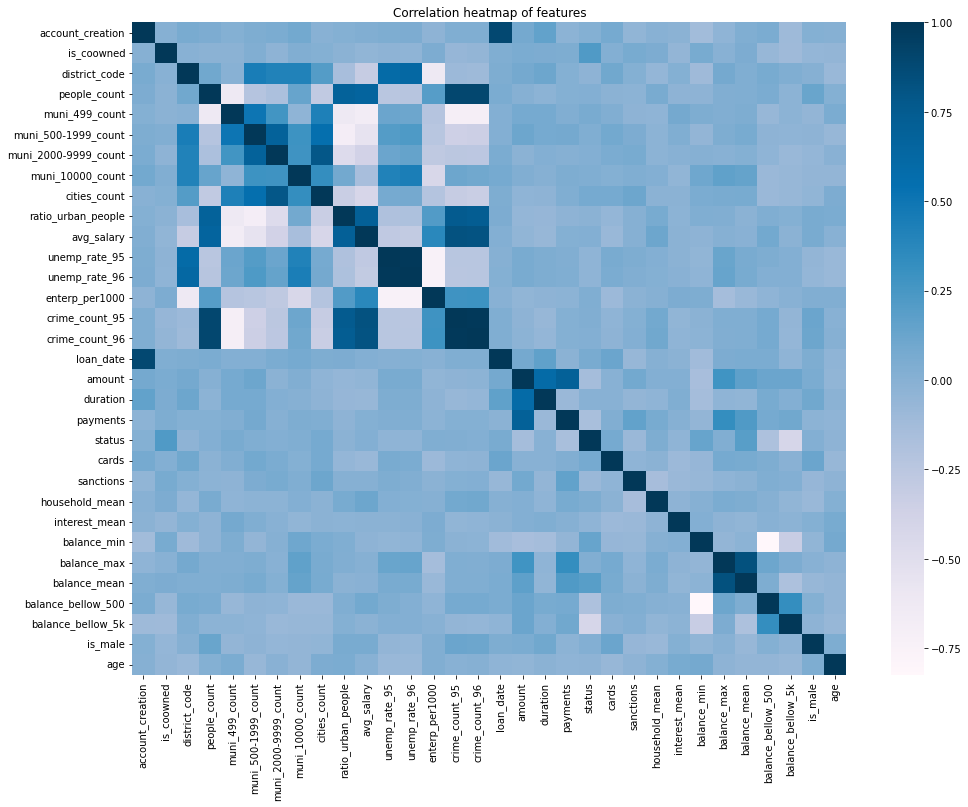

In [474]:
# create correlation matrix
corr_matrix = df.corr(method="spearman");

# create correlation heatmap
plt.figure(figsize=(16.0, 12.0))
plt.title("Correlation heatmap of features")
a = sb.heatmap(corr_matrix, linecolor='black', cmap='PuBu');
plt.show();

As we can see, most features aren't very correlated.

### Client

In [458]:
def parseYear(x):
    return x // 10000

def parseMonth(x):
    return x // 100 % 100

def parseDay(x):
    return x % 100

#### Work with client's birth_number

From this attribute we can extract the client's date of birth and gender.

<AxesSubplot:xlabel='is_male', ylabel='count'>

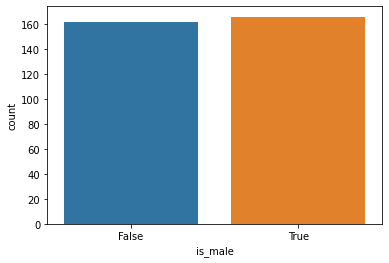

In [459]:
def identify_gender(row):
    birth = row['birth_number']
    month = (birth // 100) % 100
    return False if month > 12 else True

# create a new gender column
df['is_male'] = df.apply(identify_gender, axis=1)
df_test['is_male'] = df_test.apply(identify_gender, axis=1)

sb.countplot(x="is_male", data=df)

The genre distribution of clients who asked for loans is almost 50/50.

From the date of birth, we can derive the client's age.

In [460]:
def identify_year(df):
    def identify_year_inner(row):
        birth = row['birth_number']
        year = birth // 10000
        return year

    # create a new age column with client's age in year
    # dataset is from 99
    df['age'] = 99 - df.apply(identify_year_inner, axis=1)
    df.drop(['birth_number'], axis=1, inplace=True)
    return df

df = identify_year(df)
df_test = identify_year(df_test)

<AxesSubplot:xlabel='age', ylabel='balance_mean'>

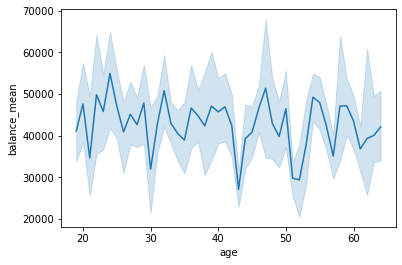

In [468]:
sb.lineplot(x="age", y="balance_mean", data=df)

#### Discretize client ages

In [ ]:
# discretize ages
age_bins=[0, 20, 29, 39, 49, 66, 150]
labels=['0-19', '20-29', '30-39', '40-49', '50-65', 'retired']
client_df['age'] = pd.cut(x=client_df['age'], bins=age_bins, labels=labels)

client_df['age']

### Loan

#### Loan date

Separa the loan date into a month and year, so it can be explored later: maybe more loans are granted during winter or summer time.

In [ ]:
# separate the loan date into loan year and loan month
def loan_ym(loan_df):
    loan_df['year_loan'] = loan_df['date'].apply(parseYear)
    loan_df['month_loan'] = loan_df['date'].apply(parseMonth)
    
loan_ym(loan_df)
loan_ym(loan_test_df)

### District

In [ ]:
sb.pairplot(district_df)

#### Unemployment rate

In [ ]:
sb.scatterplot(x=district_df["unemp_rate_95"], y=district_df["unemp_rate_96"])

The relation between the unemployment rated in 1995 and 1996 in nearlly linear (with few outliers from the trend).

From these two, we could drop the most recent (1996), as it is less likely to affect the loan decisions. This is because the decisions on loans were taken considering only data relative to before the loan was conceded.

We decided that this 2 attributes could be joined into a single one, _unem_growth_, representing the growth of the unemployment rate.

In [ ]:
district_df["unem_growth"] = (district_df["unemp_rate_96"]/district_df["unemp_rate_95"]) - 1.0

sb.scatterplot(x=district_df["unemp_rate_95"], y=district_df["unem_growth"])
district_df.drop(["unemp_rate_95", "unemp_rate_96"], axis=1, inplace=True)

In [ ]:
sb.displot(district_df["unem_growth"])

#### Crime count

In [ ]:
plt.scatter(district_df["crime_count_95"], district_df["crime_count_96"])

district_df[district_df["crime_count_95"] > 8000]

Although there is a big gap increase on the total number of crimes commited after 20000 crimes, from the plot, it can be concluded that there is a approximatelly linear correlation between the number of crimes commited in 1995 and 1996.

There are 3 regions with a much higher number of commited crimes: Prague, south Moravia, north Moravia. Even in the case of these regions, the relation is almost linear.

In [ ]:
plt.scatter(district_df["people_count"], district_df["crime_count_95"])
plt.scatter(district_df["people_count"], district_df["crime_count_96"])

In [ ]:
tmp = district_df[district_df["crime_count_95"] < 8000]
plt.scatter(tmp["people_count"], tmp["crime_count_95"])

tmp2 = district_df[district_df["crime_count_96"] < 8000]
plt.scatter(tmp2["people_count"], tmp2["crime_count_96"])

As expected, the higher the population, the more crimes are commited and this remains true for both years.

This means that it isn't a very useful information in this form. We can convert both crime counts to crime commited per 1000 habitants and use that to calculate the _crime growth_.

In [ ]:
crime_per1000_95 = district_df["crime_count_95"] / (district_df["people_count"] / 1000)
crime_per1000_96 = district_df["crime_count_96"] / (district_df["people_count"] / 1000)

district_df["crime_growth"] = (crime_per1000_96/crime_per1000_95) - 1.0

district_df.drop(["crime_count_95", "crime_count_96"], axis=1, inplace=True)

In [ ]:
plt.scatter(district_df["people_count"], district_df["crime_growth"])

This new attribute, _crime\_growth_, isn't directly related to the population size.

In [ ]:
sb.displot(district_df["crime_growth"])

#### Skewness

Some attributes are heavily _skewed_. To take care of this, we apply `np.log` to the attribute.

In [ ]:
sb.displot(district_df["people_count"])

district_df["people_count"] = np.log(district_df["people_count"])
sb.displot(district_df["people_count"])

In [ ]:
sb.displot(district_df["avg_salary"])

district_df["avg_salary"] = np.log(district_df["avg_salary"])
sb.displot(district_df["avg_salary"])

## Deal with categorical data

### Issuance frequency

The frequency is categorical data. Let's look at the cardinality of the attribute and whether it has an implicit order.

In [ ]:
df['issuance_freq'].value_counts()

There are 3  possible values for the **frquency attribute**: _monthly issuance_, _weekly issuance_, _issuance_ after transation. There is an implicit order between weekly and monthly, but with _issuance after transation_ it isn't so obvious. It was decided that, since it is expected that people do more than 1 transaction per week, _issuance after transation_ also relates to the other 2 in terms of time.

When considering the time intervals between transations: _issuance after transation_ < _weekly issuance_ < _monthly issuance_.

There is also a magnitude difference between all of them, e.g.: monthly is around 4 times more frequent than weekly. This raises the issue of how much more frequent is _issuance after transaction_ than _weekly issuance_. Let's assume the _weekly issuance_ is 7 time less frequent.

Let's replace this categorical data by ordered integers:

In [ ]:
df.replace({'issuance_freq':
                {'issuance after transaction': 1,
                 'weekly issuance': 7,
                 'monthly issuance': 30}
            }, inplace=True)
df['issuance_freq']

### Client age

_client_age_ is a categorical value. Each category represents a range. This ranges can be divided into 2 attributes: the start and the end of the range.

In [ ]:
def uncat_age_bins(row, is_begin=True):
    age = row['client_age']
    if age == 'retired':
        return 66 if is_begin else 150
    return age.split('-')[0 if is_begin else 1]
    

df['age_start'] = df.apply(uncat_age_bins, axis=1)
df['age_end'] = df.apply(lambda x: uncat_age_bins(x, False), axis=1)

df.drop(['client_age'], axis=1, inplace=True)

df.head()

### District data

Both name and region are categorical data relating to regions.

In [ ]:
print("Number of different 'code' values:", len(df['district_code'].value_counts()))
print("Number of different 'name' values:", len(df['district_name'].value_counts()))

We can see that there is a direct association between the **code** and **name** attributes. This means they are redundant and we don't have to deal with the **name** attribute.

There is a problem with this. The **code** attributes are integers which indirectly imply an order, even though the names of the regions are nominal features, but it encoding it would generate too many attributes, so it was decided that it would be dropped.

In [ ]:
df.drop(['district_name'], axis=1, inplace=True)

The **region** feature is categorial and there is no order associated. This means this attribute should be encoded in order to remove it's categorical nature and still remain unordered. One-Hot encoding could be used for simplicity, but Binary enconding is be better.

In [ ]:
df['region'].value_counts()

In [ ]:
from category_encoders import BinaryEncoder

encoder = BinaryEncoder(cols=['region'])
df = encoder.fit_transform(df)
df.head()

### Transaction data

There are also 4 categorical attributes in this dataframe: _type_, _operation_, _k\_symbol_, and _bank_.

In [ ]:
#trans_df['type'].value_counts()

The _type_ attribute has 3 categories with no distinct order between them.

In [ ]:
#from category_encoders import BinaryEncoder

#encoder = BinaryEncoder(cols=['type'])
#trans_df = encoder.fit_transform(trans_df)
#trans_df.head()

This data could have been encoded with One-Hot encoding, which is simpler. Binary encoding is used in order to use 1 less attribute.

In [ ]:
#trans_df.drop(['operation', 'k_symbol', 'bank'], axis=1, inplace=True)

## Classification

In [ ]:
def getXy(df):
    # inputs
    X = df.drop(["status"], axis=1)
    # target
    y = df["status"]
    return (X, y)

X_train, y_train = getXy(df)
# // TODO scale data?

Note that we scaled our data. We did this because we need it to obtain better results on distance-based models: K-NN and SVC. This doesn't affect tree-based algorithms so we do it here.

In [ ]:
from sklearn.model_selection import StratifiedKFold

k = 10
kf = StratifiedKFold(n_splits=k)

We will be using **Stratified K-Fold with 10 folds** for our cross-validations.

### Establishing a baseline

Let's establish a baseline for our classifiers.

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

baseline_clfs = [
    {"name": "Decision tree", "clf": DecisionTreeClassifier()},
    #{"name": "K-Nearest neighbors", "clf": KNeighborsClassifier()},
    {"name": "Naive Bayes", "clf": GaussianNB()},
]

scoring = {"accuracy": "accuracy",
           "precision": "precision_weighted",
           "recall": "recall_weighted",
           "f1": "f1_weighted"}

# save classifier information in DataFrame: name, score, fit_time, score_time
baseline_df = pd.DataFrame()
for clf_entry in baseline_clfs:
    scores = cross_validate(clf_entry["clf"], X_train, y_train, scoring=scoring, cv=kf, n_jobs=configNJobs)
    info = scores | {"classifier": [clf_entry["name"]] * k}
    baseline_df = baseline_df.append(pd.DataFrame(info))

baseline_df